<a href="https://colab.research.google.com/github/alexandre-pinon/voltron/blob/feature%2Fai/bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily Climate time series data analysis

## Config

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from sklearn.preprocessing import minmax_scale

In [2]:
# Check for GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-40e49d7d-28f8-2e42-5423-abd4e1b056f4)


In [3]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
EPOCHS = 100
BATCH_SIZE = 128

## Data loading

In [4]:
# Parse dates and set date column to index
train_df = pd.read_csv("./data/DailyDelhiClimateTrain.csv",
                       parse_dates=["date"],
                       index_col=["date"])
test_df = pd.read_csv("./data/DailyDelhiClimateTest.csv",
                      parse_dates=["date"],
                      index_col=["date"])

## Data vizualisation

In [131]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [132]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [5]:
def plot_time_series(ax,
                     timesteps,
                     values,
                     title=None,
                     format='.',
                     start=0,
                     end=None,
                     label=None,
                     c='b'):
    """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  ax : matplotlib.Axes to plot
  timesteps : array of timesteps
  values : array of values across time
  title : title of plot
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  c : color, default 'blue'
  """
    ax.plot(timesteps[start:end], values[start:end], format, c=c, label=label)
    ax.set_xlabel("Time")
    ax.tick_params('x', labelrotation=45)
    ax.grid(True)

    if title:
        ax.set_title(title, fontsize=16)
    if label:
        ax.legend(fontsize=14, bbox_to_anchor=(1, 1), loc='upper left')


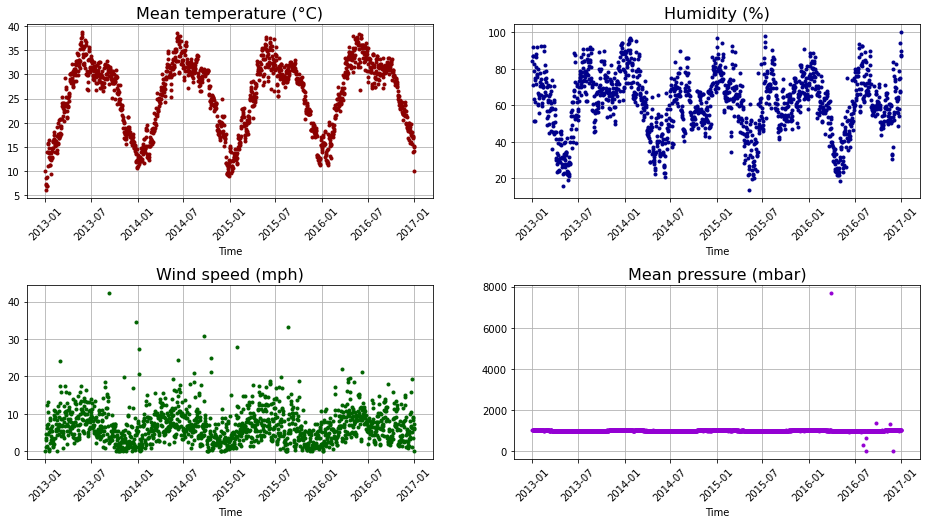

In [133]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,
                                             2,
                                             figsize=(16, 8),
                                             gridspec_kw={'hspace': .5})

plot_time_series(ax1,
                 train_df.index,
                 train_df["meantemp"],
                 "Mean temperature (°C)",
                 c='darkred')
plot_time_series(ax2,
                 train_df.index,
                 train_df["humidity"],
                 "Humidity (%)",
                 c='darkblue')
plot_time_series(ax3,
                 train_df.index,
                 train_df["wind_speed"],
                 "Wind speed (mph)",
                 c='darkgreen')
plot_time_series(ax4,
                 train_df.index,
                 train_df["meanpressure"],
                 "Mean pressure (mbar)",
                 c='darkviolet')

# fig.savefig('./graphs/train_data.png', facecolor='white')

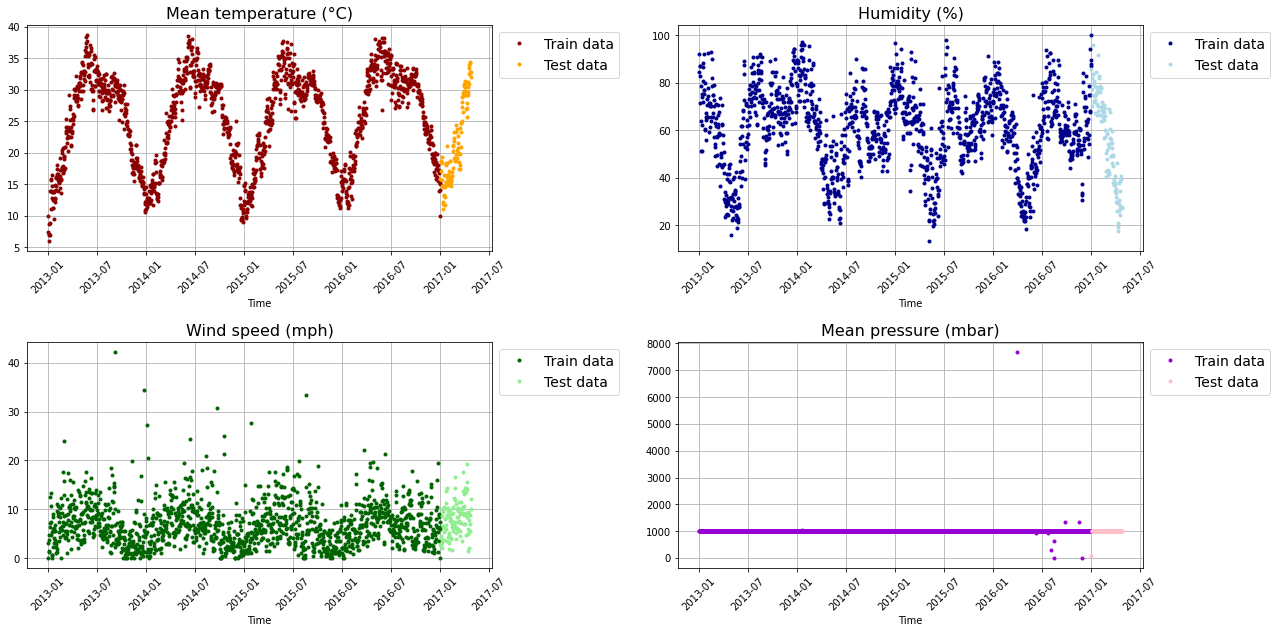

In [134]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,
                                             2,
                                             figsize=(20, 10),
                                             gridspec_kw={
                                                 'wspace': .4,
                                                 'hspace': .4
                                             })

plot_time_series(ax1,
                 train_df.index,
                 train_df["meantemp"],
                 "Mean temperature (°C)",
                 label='Train data',
                 c='darkred')
plot_time_series(ax1,
                 test_df.index,
                 test_df["meantemp"],
                 "Mean temperature (°C)",
                 label='Test data',
                 c='orange')
plot_time_series(ax2,
                 train_df.index,
                 train_df["humidity"],
                 "Humidity (%)",
                 label='Train data',
                 c='darkblue')
plot_time_series(ax2,
                 test_df.index,
                 test_df["humidity"],
                 "Humidity (%)",
                 label='Test data',
                 c='lightblue')
plot_time_series(ax3,
                 train_df.index,
                 train_df["wind_speed"],
                 "Wind speed (mph)",
                 label='Train data',
                 c='darkgreen')
plot_time_series(ax3,
                 test_df.index,
                 test_df["wind_speed"],
                 "Wind speed (mph)",
                 label='Test data',
                 c='lightgreen')
plot_time_series(ax4,
                 train_df.index,
                 train_df["meanpressure"],
                 "Mean pressure (mbar)",
                 label='Train data',
                 c='darkviolet')
plot_time_series(ax4,
                 test_df.index,
                 test_df["meanpressure"],
                 "Mean pressure (mbar)",
                 label='Test data',
                 c='pink')

# fig.savefig('./graphs/train_plus_test_data.png', facecolor='white')

# Univariate predictions on mean temperature

## Model 0 : Naïve forecast (baseline)

Let's start with a baseline: the [Naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)

For naïve forecasts, we simply set all forecasts to be the value of the last observation. That is,
\begin{equation*}
  y_t = y_{t-1} 
\end{equation*}

In [14]:
df = pd.concat([train_df, test_df])
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


In [15]:
X = df.index
y = df["meantemp"]

In [139]:
X, y

(DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
                '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
                '2013-01-09', '2013-01-10',
                ...
                '2017-04-15', '2017-04-16', '2017-04-17', '2017-04-18',
                '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
                '2017-04-23', '2017-04-24'],
               dtype='datetime64[ns]', name='date', length=1576, freq=None),
 date
 2013-01-01    10.000000
 2013-01-02     7.400000
 2013-01-03     7.166667
 2013-01-04     8.666667
 2013-01-05     6.000000
                 ...    
 2017-04-20    34.500000
 2017-04-21    34.250000
 2017-04-22    32.900000
 2017-04-23    32.875000
 2017-04-24    32.000000
 Name: meantemp, Length: 1576, dtype: float64)

In [146]:
# Make train, val and test sets
train_size = int(len(X) * TRAIN_SIZE)
val_size = int(len(X) * VAL_SIZE)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size +
                                                      val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [147]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print("-" * 30)
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1260,)
X_val shape: (157,)
X_test shape: (159,)
------------------------------
y_train shape: (1260,)
y_val shape: (157,)
y_test shape: (159,)


In [148]:
# Naïve forecast equals every value excluding the last value
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]  # View frist 10 and last 10

(date
 2016-11-18    21.730769
 2016-11-19    20.666667
 2016-11-20    22.250000
 2016-11-21    21.538462
 2016-11-22    22.578947
 2016-11-23    22.826087
 2016-11-24    21.421053
 2016-11-25    23.600000
 2016-11-26    24.294118
 2016-11-27    23.636364
 Name: meantemp, dtype: float64,
 date
 2017-04-14    30.500000
 2017-04-15    31.222222
 2017-04-16    31.000000
 2017-04-17    32.555556
 2017-04-18    34.000000
 2017-04-19    33.500000
 2017-04-20    34.500000
 2017-04-21    34.250000
 2017-04-22    32.900000
 2017-04-23    32.875000
 Name: meantemp, dtype: float64)

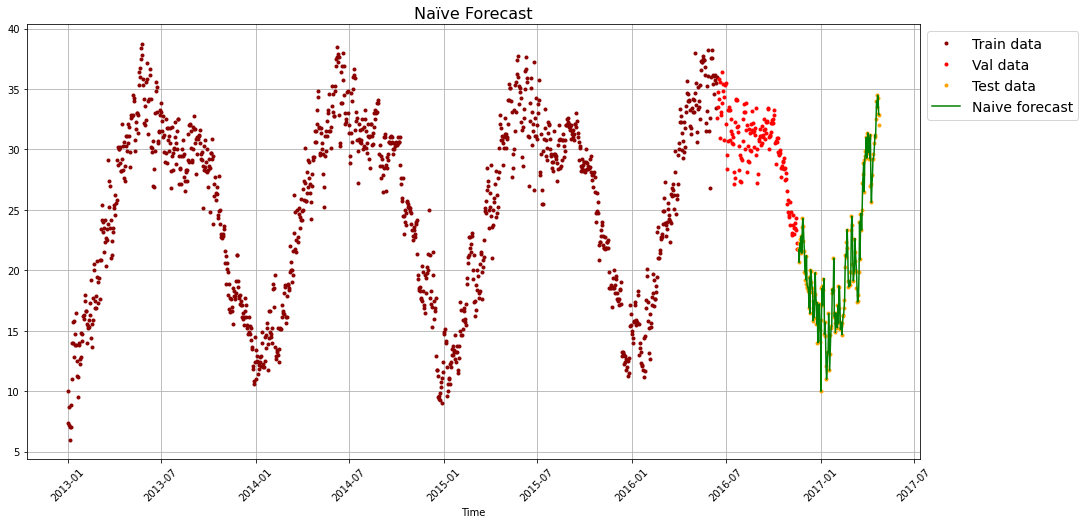

In [149]:
# Plot naive forecast
fig, ax = plt.subplots(figsize=(16, 8))
plot_time_series(ax, X_train, y_train, label="Train data", c='darkred')
plot_time_series(ax, X_val, y_val, label="Val data", c='red')
plot_time_series(ax, X_test, y_test, label="Test data", c='orange')
plot_time_series(ax,
                 X_test[1:],
                 naive_forecast,
                 title="Naïve Forecast",
                 format="-",
                 label="Naive forecast",
                 c='green')

Let's zoom in to get a better look

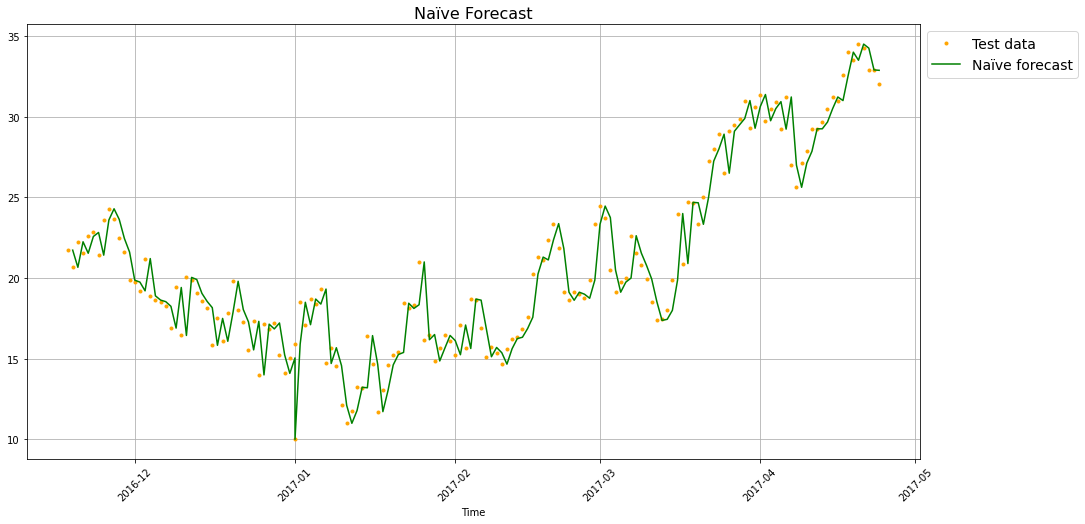

In [150]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_time_series(ax, X_test, y_test, label="Test data", c='orange')
plot_time_series(ax,
                 X_test[1:],
                 naive_forecast,
                 title="Naïve Forecast",
                 format="-",
                 label="Naïve forecast",
                 c='green')

# fig.savefig('./graphs/model_0_naive_forecast.png', facecolor='white')

## Evaluate model

In [6]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
  Implement MASE (assuming no seasonality of data).
  """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    # our seasonality is 1 day (hence the shifting of 1 day)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_no_season

In [7]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    # puts and emphasis on outliers (all errors get squared)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    print(mase)

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }

In [153]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
pd.Series(naive_results)

tf.Tensor(0.99855644, shape=(), dtype=float32)


mae     1.376523
mse     3.141388
rmse    1.772396
mape    7.327091
mase    0.998556
dtype: float32

In [154]:
# Find average mean temperature in test dataset
tf.reduce_mean(y_test).numpy()

20.890680415740142

## Windowing dataset

Windowing is a method to turn a time series dataset into supervised learning problem.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (window=7) to predict the next single value (horizon=1) might look like:

Window for one week (univariate time series)

- [0, 1, 2, 3, 4, 5, 6] -> [7]
- [1, 2, 3, 4, 5, 6, 7] -> [8]
- [2, 3, 4, 5, 6, 7, 8] -> [9]

In [8]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
    """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
    return x[:, :-horizon], x[:, -horizon:]

In [9]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
    """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(
        np.arange(len(x) - (window_size + horizon - 1)),
        axis=0).T  # create 2D array of windows of size window_size

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

## Creating training/validation/test datasets

In [158]:
WINDOW_SIZE = 7  # use a week worth of timesteps to predict the horizon
HORIZON = 1  # predict 1 step at a time

In [159]:
train_windows, train_labels = make_windows(y_train.to_numpy(),
                                           window_size=WINDOW_SIZE,
                                           horizon=HORIZON)
val_windows, val_labels = make_windows(y_val.to_numpy(),
                                       window_size=WINDOW_SIZE,
                                       horizon=HORIZON)
test_windows, test_labels = make_windows(y_test.to_numpy(),
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

In [160]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {train_windows[i]} -> Label: {train_labels[i]}")

# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {train_windows[i-3]} -> Label: {train_labels[i-3]}")


Window: [10.          7.4         7.16666667  8.66666667  6.          7.
  7.        ] -> Label: [8.85714286]
Window: [7.4        7.16666667 8.66666667 6.         7.         7.
 8.85714286] -> Label: [14.]
Window: [ 7.16666667  8.66666667  6.          7.          7.          8.85714286
 14.        ] -> Label: [11.]
Window: [38.2        36.16666667 35.42857143 34.625      36.07142857 35.73333333
 36.13333333] -> Label: [33.4375]
Window: [36.16666667 35.42857143 34.625      36.07142857 35.73333333 36.13333333
 33.4375    ] -> Label: [35.5]
Window: [35.42857143 34.625      36.07142857 35.73333333 36.13333333 33.4375
 35.5       ] -> Label: [36.]


In [161]:
print(f"train_windows shape: {train_windows.shape}")
print(f"val_windows shape: {val_windows.shape}")
print(f"test_windows shape: {test_windows.shape}")
print("-" * 30)
print(f"train_labels shape: {train_labels.shape}")
print(f"val_labels shape: {val_labels.shape}")
print(f"test_labels shape: {test_labels.shape}")

train_windows shape: (1253, 7)
val_windows shape: (150, 7)
test_windows shape: (152, 7)
------------------------------
train_labels shape: (1253, 1)
val_labels shape: (150, 1)
test_labels shape: (152, 1)


## Model checkpoint

In [10]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        # create filepath to save model
        filepath=os.path.join(save_path, model_name),
        verbose=0,  # only output a limited amount of text
        save_best_only=True)  # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)


In [165]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential(
    [
        layers.Dense(128, activation="relu"),
        # linear activation is the same as having no activation
        layers.Dense(HORIZON, activation="linear")
    ],
    name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(
    x=train_windows,  # train windows of 7 days
    y=train_labels,  # horizon value of 1 (using the previous 7 timesteps to predict next day)
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
    validation_data=(val_windows, val_labels),
    # create ModelCheckpoint callback to save best model
    callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/100
 1/10 [==>...........................] - ETA: 1s - loss: 15.4854 - mae: 15.4854INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 1s 40ms/step - loss: 8.9357 - mae: 8.9357 - val_loss: 1.4061 - val_mae: 1.4061
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 2.8128 - mae: 2.8128 - val_loss: 2.8746 - val_mae: 2.8746
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 1.8694 - mae: 1.8694 - val_loss: 1.8026 - val_mae: 1.8026
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 1.7552 - mae: 1.7552 - val_loss: 1.8267 - val_mae: 1.8267
Epoch 5/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.8117 - mae: 1.8117INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.6712 - mae: 1.6712 - val_loss: 1.3330 - val_mae: 1.3330
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 1.5696 - mae: 1.5696 - val_loss: 1.3497 - val_mae: 1.3497
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 1.5164 - mae: 1.5164 - val_loss: 1.3649 - val_mae: 1.3649
Epoch 8/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.3399 - mae: 1.3399INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.4938 - mae: 1.4938 - val_loss: 1.2541 - val_mae: 1.2541
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 1.4658 - mae: 1.4658 - val_loss: 1.3054 - val_mae: 1.3054
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 1.4499 - mae: 1.4499 - val_loss: 1.2624 - val_mae: 1.2624
Epoch 11/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.3871 - mae: 1.3871INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.4421 - mae: 1.4421 - val_loss: 1.2373 - val_mae: 1.2373
Epoch 12/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.5731 - mae: 1.5731INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.4433 - mae: 1.4433 - val_loss: 1.2293 - val_mae: 1.2293
Epoch 13/100
10/10 [==============================] - 0s 7ms/step - loss: 1.4313 - mae: 1.4313 - val_loss: 1.3796 - val_mae: 1.3796
Epoch 14/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.4410 - mae: 1.4410INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.4056 - mae: 1.4056 - val_loss: 1.2068 - val_mae: 1.2068
Epoch 15/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.4882 - mae: 1.4882INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 32ms/step - loss: 1.4029 - mae: 1.4029 - val_loss: 1.2055 - val_mae: 1.2055
Epoch 16/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3862 - mae: 1.3862 - val_loss: 1.2791 - val_mae: 1.2791
Epoch 17/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3863 - mae: 1.3863 - val_loss: 1.2745 - val_mae: 1.2745
Epoch 18/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.4008 - mae: 1.4008INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.3660 - mae: 1.3660 - val_loss: 1.1779 - val_mae: 1.1779
Epoch 19/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.4614 - mae: 1.4614INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.3643 - mae: 1.3643 - val_loss: 1.1679 - val_mae: 1.1679
Epoch 20/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3553 - mae: 1.3553 - val_loss: 1.1679 - val_mae: 1.1679
Epoch 21/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.3380 - mae: 1.3380INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 32ms/step - loss: 1.3361 - mae: 1.3361 - val_loss: 1.1524 - val_mae: 1.1524
Epoch 22/100
10/10 [==============================] - 0s 7ms/step - loss: 1.3455 - mae: 1.3455 - val_loss: 1.1548 - val_mae: 1.1548
Epoch 23/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.2959 - mae: 1.2959INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 35ms/step - loss: 1.3544 - mae: 1.3544 - val_loss: 1.1474 - val_mae: 1.1474
Epoch 24/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3294 - mae: 1.3294 - val_loss: 1.1479 - val_mae: 1.1479
Epoch 25/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.3823 - mae: 1.3823INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.3237 - mae: 1.3237 - val_loss: 1.1439 - val_mae: 1.1439
Epoch 26/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.2243 - mae: 1.2243INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.3069 - mae: 1.3069 - val_loss: 1.1372 - val_mae: 1.1372
Epoch 27/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.3738 - mae: 1.3738INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.3018 - mae: 1.3018 - val_loss: 1.1348 - val_mae: 1.1348
Epoch 28/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3112 - mae: 1.3112 - val_loss: 1.1375 - val_mae: 1.1375
Epoch 29/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3357 - mae: 1.3357 - val_loss: 1.1506 - val_mae: 1.1506
Epoch 30/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3143 - mae: 1.3143 - val_loss: 1.1373 - val_mae: 1.1373
Epoch 31/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3117 - mae: 1.3117 - val_loss: 1.1361 - val_mae: 1.1361
Epoch 32/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.1129 - mae: 1.1129INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.2873 - mae: 1.2873 - val_loss: 1.1282 - val_mae: 1.1282
Epoch 33/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2903 - mae: 1.2903 - val_loss: 1.1340 - val_mae: 1.1340
Epoch 34/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2896 - mae: 1.2896 - val_loss: 1.1421 - val_mae: 1.1421
Epoch 35/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2756 - mae: 1.2756 - val_loss: 1.1388 - val_mae: 1.1388
Epoch 36/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.3090 - mae: 1.3090INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.2988 - mae: 1.2988 - val_loss: 1.1103 - val_mae: 1.1103
Epoch 37/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2886 - mae: 1.2886 - val_loss: 1.3065 - val_mae: 1.3065
Epoch 38/100
10/10 [==============================] - 0s 7ms/step - loss: 1.3021 - mae: 1.3021 - val_loss: 1.1588 - val_mae: 1.1588
Epoch 39/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.2594 - mae: 1.2594INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.2844 - mae: 1.2844 - val_loss: 1.1014 - val_mae: 1.1014
Epoch 40/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2700 - mae: 1.2700 - val_loss: 1.1021 - val_mae: 1.1021
Epoch 41/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.3567 - mae: 1.3567INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.2655 - mae: 1.2655 - val_loss: 1.1004 - val_mae: 1.1004
Epoch 42/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.2343 - mae: 1.2343INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.2773 - mae: 1.2773 - val_loss: 1.0945 - val_mae: 1.0945
Epoch 43/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3248 - mae: 1.3248 - val_loss: 1.1101 - val_mae: 1.1101
Epoch 44/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2963 - mae: 1.2963 - val_loss: 1.1319 - val_mae: 1.1319
Epoch 45/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2827 - mae: 1.2827 - val_loss: 1.1369 - val_mae: 1.1369
Epoch 46/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2721 - mae: 1.2721 - val_loss: 1.1342 - val_mae: 1.1342
Epoch 47/100
10/10 [==============================] - 0s 5ms/step - loss: 1.2582 - mae: 1.2582 - val_loss: 1.1294 - val_mae: 1.1294
Epoch 48/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2721 - mae: 1.2721 - val_loss: 1.1086 - val_mae: 1.1086
Epoch 49/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2550 - mae: 

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.2576 - mae: 1.2576 - val_loss: 1.0886 - val_mae: 1.0886
Epoch 51/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2552 - mae: 1.2552 - val_loss: 1.1171 - val_mae: 1.1171
Epoch 52/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2652 - mae: 1.2652 - val_loss: 1.0954 - val_mae: 1.0954
Epoch 53/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.2711 - mae: 1.2711INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.2487 - mae: 1.2487 - val_loss: 1.0855 - val_mae: 1.0855
Epoch 54/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2492 - mae: 1.2492 - val_loss: 1.1069 - val_mae: 1.1069
Epoch 55/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2783 - mae: 1.2783 - val_loss: 1.1352 - val_mae: 1.1352
Epoch 56/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2559 - mae: 1.2559 - val_loss: 1.0867 - val_mae: 1.0867
Epoch 57/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2567 - mae: 1.2567 - val_loss: 1.1141 - val_mae: 1.1141
Epoch 58/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.1631 - mae: 1.1631INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.2748 - mae: 1.2748 - val_loss: 1.0828 - val_mae: 1.0828
Epoch 59/100
10/10 [==============================] - 0s 7ms/step - loss: 1.2544 - mae: 1.2544 - val_loss: 1.0903 - val_mae: 1.0903
Epoch 60/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2521 - mae: 1.2521 - val_loss: 1.0869 - val_mae: 1.0869
Epoch 61/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.2504 - mae: 1.2504INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 32ms/step - loss: 1.2476 - mae: 1.2476 - val_loss: 1.0794 - val_mae: 1.0794
Epoch 62/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2396 - mae: 1.2396 - val_loss: 1.0874 - val_mae: 1.0874
Epoch 63/100
10/10 [==============================] - 0s 7ms/step - loss: 1.2466 - mae: 1.2466 - val_loss: 1.2225 - val_mae: 1.2225
Epoch 64/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.2011 - mae: 1.2011INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.2615 - mae: 1.2615 - val_loss: 1.0792 - val_mae: 1.0792
Epoch 65/100
10/10 [==============================] - 0s 7ms/step - loss: 1.2681 - mae: 1.2681 - val_loss: 1.0973 - val_mae: 1.0973
Epoch 66/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.1897 - mae: 1.1897INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.2594 - mae: 1.2594 - val_loss: 1.0774 - val_mae: 1.0774
Epoch 67/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2503 - mae: 1.2503 - val_loss: 1.1849 - val_mae: 1.1849
Epoch 68/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.4714 - mae: 1.4714INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.2584 - mae: 1.2584 - val_loss: 1.0738 - val_mae: 1.0738
Epoch 69/100
10/10 [==============================] - 0s 7ms/step - loss: 1.2640 - mae: 1.2640 - val_loss: 1.1064 - val_mae: 1.1064
Epoch 70/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2476 - mae: 1.2476 - val_loss: 1.1205 - val_mae: 1.1205
Epoch 71/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2683 - mae: 1.2683 - val_loss: 1.1695 - val_mae: 1.1695
Epoch 72/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2831 - mae: 1.2831 - val_loss: 1.1033 - val_mae: 1.1033
Epoch 73/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.1906 - mae: 1.1906INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.3068 - mae: 1.3068 - val_loss: 1.0716 - val_mae: 1.0716
Epoch 74/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2722 - mae: 1.2722 - val_loss: 1.1239 - val_mae: 1.1239
Epoch 75/100
10/10 [==============================] - 0s 5ms/step - loss: 1.2447 - mae: 1.2447 - val_loss: 1.1354 - val_mae: 1.1354
Epoch 76/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2624 - mae: 1.2624 - val_loss: 1.2688 - val_mae: 1.2688
Epoch 77/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.2364 - mae: 1.2364INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.2434 - mae: 1.2434 - val_loss: 1.0681 - val_mae: 1.0681
Epoch 78/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2508 - mae: 1.2508 - val_loss: 1.1352 - val_mae: 1.1352
Epoch 79/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2582 - mae: 1.2582 - val_loss: 1.1300 - val_mae: 1.1300
Epoch 80/100
10/10 [==============================] - 0s 5ms/step - loss: 1.2471 - mae: 1.2471 - val_loss: 1.0694 - val_mae: 1.0694
Epoch 81/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2410 - mae: 1.2410 - val_loss: 1.0954 - val_mae: 1.0954
Epoch 82/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2290 - mae: 1.2290 - val_loss: 1.0866 - val_mae: 1.0866
Epoch 83/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2415 - mae: 1.2415 - val_loss: 1.1130 - val_mae: 1.1130
Epoch 84/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2388 - mae: 

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


10/10 [==============================] - 0s 34ms/step - loss: 1.2414 - mae: 1.2414 - val_loss: 1.0615 - val_mae: 1.0615
Epoch 95/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2545 - mae: 1.2545 - val_loss: 1.1176 - val_mae: 1.1176
Epoch 96/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2512 - mae: 1.2512 - val_loss: 1.1797 - val_mae: 1.1797
Epoch 97/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2396 - mae: 1.2396 - val_loss: 1.0761 - val_mae: 1.0761
Epoch 98/100
10/10 [==============================] - 0s 5ms/step - loss: 1.2354 - mae: 1.2354 - val_loss: 1.0673 - val_mae: 1.0673
Epoch 99/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2297 - mae: 1.2297 - val_loss: 1.0858 - val_mae: 1.0858
Epoch 100/100
10/10 [==============================] - 0s 6ms/step - loss: 1.2444 - mae: 1.2444 - val_loss: 1.1443 - val_mae: 1.1443


In [166]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

5/5 [==============================] - 0s 3ms/step - loss: 1.4224 - mae: 1.4224


[1.4223781824111938, 1.4223781824111938]

In [167]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

5/5 [==============================] - 0s 2ms/step - loss: 1.3755 - mae: 1.3755


[1.3754997253417969, 1.3754997253417969]

In [11]:
def make_preds(model, input_data):
    """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)  # return 1D array of predictions

In [169]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

5/5 [==============================] - 0s 1ms/step


(152,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([21.686235, 23.178036, 24.077703, 23.540804, 22.669086, 22.035305,
        20.499676, 20.259785, 19.87159 , 21.237486], dtype=float32)>)

In [170]:
# Evaluate preds
model_1_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),  # reduce to right shape
    y_pred=model_1_preds)
pd.Series(model_1_results)

tf.Tensor(0.9925472, shape=(), dtype=float32)


mae     1.375500
mse     3.004024
rmse    1.733212
mape    7.297487
mase    0.992547
dtype: float32

In [171]:
pd.Series(naive_results)

mae     1.376523
mse     3.141388
rmse    1.772396
mape    7.327091
mase    0.998556
dtype: float32

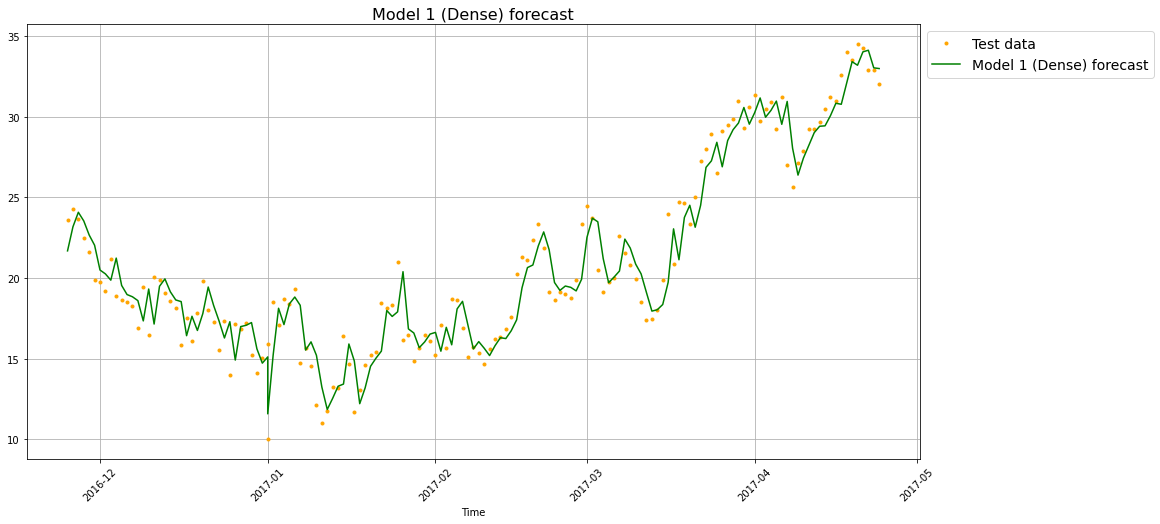

In [172]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_time_series(ax,
                 X_test[-len(test_windows):],
                 test_labels[:, 0],
                 label="Test data",
                 c='orange')
plot_time_series(ax,
                 X_test[-len(test_windows):],
                 model_1_preds,
                 title="Model 1 (Dense) forecast",
                 format="-",
                 label="Model 1 (Dense) forecast",
                 c='green')

# fig.savefig('./graphs/model_1_dense_forecast.png', facecolor='white')

## Model 2: Dense (window = 30, horizon = 1)

In [196]:
WINDOW_SIZE = 30  # use 30 timesteps in the past
HORIZON = 1  # predict one step at a time

In [197]:
train_windows, train_labels = make_windows(y_train.to_numpy(),
                                           window_size=WINDOW_SIZE,
                                           horizon=HORIZON)
val_windows, val_labels = make_windows(y_val.to_numpy(),
                                       window_size=WINDOW_SIZE,
                                       horizon=HORIZON)
test_windows, test_labels = make_windows(y_test.to_numpy(),
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

In [198]:
print(f"train_windows shape: {train_windows.shape}")
print(f"val_windows shape: {val_windows.shape}")
print(f"test_windows shape: {test_windows.shape}")
print("-" * 30)
print(f"train_labels shape: {train_labels.shape}")
print(f"val_labels shape: {val_labels.shape}")
print(f"test_labels shape: {test_labels.shape}")

train_windows shape: (1230, 30)
val_windows shape: (127, 30)
test_windows shape: (129, 30)
------------------------------
train_labels shape: (1230, 1)
val_labels shape: (127, 1)
test_labels shape: (129, 1)


In [199]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential(
    [
        layers.Dense(128, activation="relu"),
        # need to predict horizon number of steps into the future
        layers.Dense(HORIZON)
    ],
    name="model_2_dense")

model_2.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            validation_data=(val_windows, val_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


In [200]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

5/5 [==============================] - 0s 2ms/step - loss: 1.4996


1.4995872974395752

In [201]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

5/5 [==============================] - 0s 3ms/step - loss: 1.4996


1.4995872974395752

In [202]:
# Get forecast predictions
model_2_preds = make_preds(model_2, input_data=test_windows)

5/5 [==============================] - 0s 1ms/step


In [203]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),  # remove 1 dimension of test labels
    y_pred=model_2_preds)
pd.Series(model_2_results)

mae     1.499587
mse     3.533432
rmse    1.879743
mape    7.892293
mase    1.061690
dtype: float32

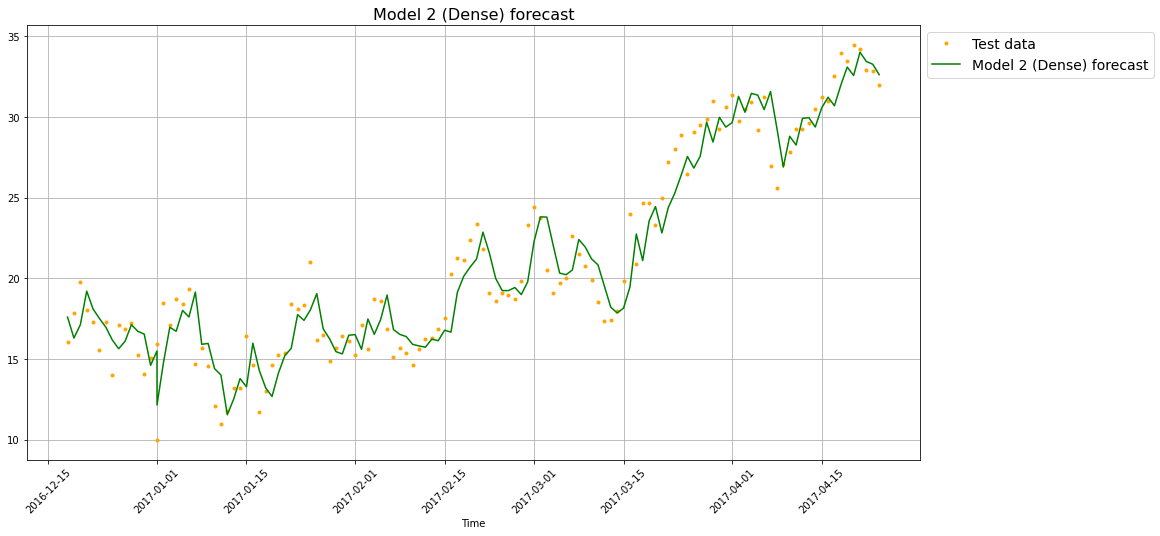

In [204]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_time_series(ax,
                 X_test[-len(test_windows):],
                 test_labels[:, 0],
                 label="Test data",
                 c='orange')
plot_time_series(ax,
                 X_test[-len(test_windows):],
                 model_2_preds,
                 title="Model 2 (Dense) forecast",
                 format="-",
                 label="Model 2 (Dense) forecast",
                 c='green')

# fig.savefig('./graphs/model_2_dense_forecast.png', facecolor='white')

## Model 3: Dense (window = 30, horizon = 7)

In [205]:
WINDOW_SIZE = 30
HORIZON = 7

In [206]:
train_windows, train_labels = make_windows(y_train.to_numpy(),
                                           window_size=WINDOW_SIZE,
                                           horizon=HORIZON)
val_windows, val_labels = make_windows(y_val.to_numpy(),
                                       window_size=WINDOW_SIZE,
                                       horizon=HORIZON)
test_windows, test_labels = make_windows(y_test.to_numpy(),
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

In [207]:
print(f"train_windows shape: {train_windows.shape}")
print(f"val_windows shape: {val_windows.shape}")
print(f"test_windows shape: {test_windows.shape}")
print("-" * 30)
print(f"train_labels shape: {train_labels.shape}")
print(f"val_labels shape: {val_labels.shape}")
print(f"test_labels shape: {test_labels.shape}")

train_windows shape: (1224, 30)
val_windows shape: (121, 30)
test_windows shape: (123, 30)
------------------------------
train_labels shape: (1224, 7)
val_labels shape: (121, 7)
test_labels shape: (123, 7)


In [208]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential(
    [layers.Dense(128, activation="relu"),
     layers.Dense(HORIZON)],
    name="model_3_dense")

model_3.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            validation_data=(val_windows, val_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


In [209]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

4/4 [==============================] - 0s 3ms/step - loss: 2.3390


2.3390002250671387

In [210]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

4/4 [==============================] - 0s 3ms/step - loss: 2.3847


2.384730339050293

In [211]:
model_3_preds = make_preds(model_3, input_data=test_windows)
model_3_preds[:5]

4/4 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[18.059145, 17.4867  , 17.503246, 17.486265, 16.864107, 17.51389 ,
        17.447836],
       [16.9858  , 16.9761  , 16.915842, 16.448895, 16.957617, 16.921127,
        16.702738],
       [17.37843 , 17.27344 , 16.575895, 17.220034, 17.133995, 17.619656,
        16.769659],
       [18.583195, 17.729776, 17.720957, 17.24584 , 18.04452 , 17.757343,
        17.1185  ],
       [17.876308, 17.885746, 17.57156 , 18.487514, 17.497782, 17.106544,
        16.837898]], dtype=float32)>

In [212]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
pd.Series(model_3_results)

mae      2.384730
mse      9.021269
rmse     2.755275
mape    11.918072
mase     1.673916
dtype: float32

### Make our evaluation function work for larger horizons

In [12]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, reduce to single number)
    if mae.ndim > 0:  # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }

In [214]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
pd.Series(model_3_results)

mae      2.384730
mse      9.021269
rmse     2.755275
mape    11.918072
mase     1.673916
dtype: float32

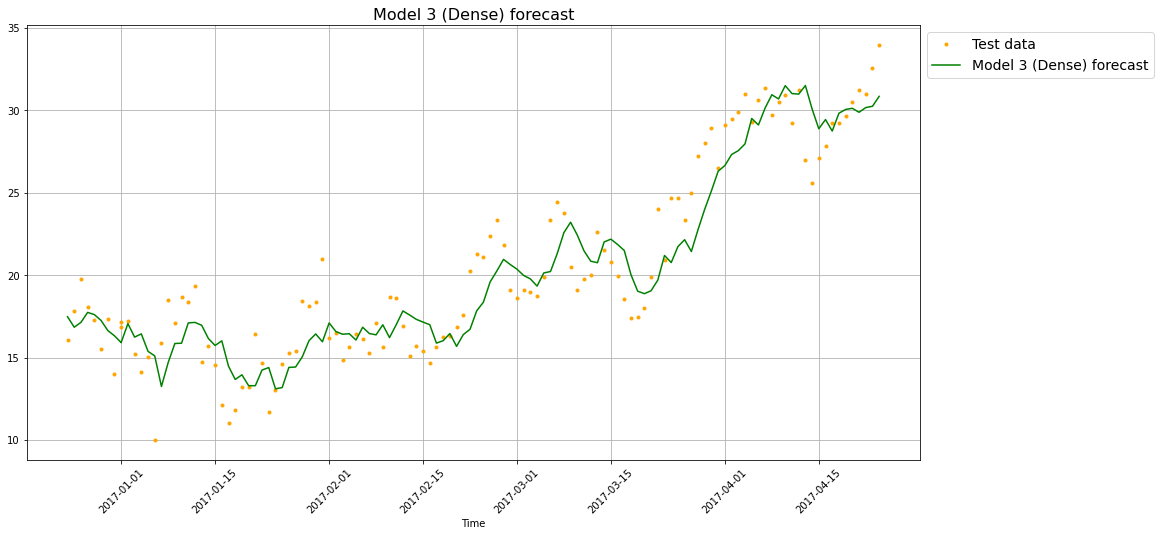

In [215]:
fig, ax = plt.subplots(figsize=(16, 8))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(ax,
                 X_test[-len(test_windows):],
                 test_labels[:, 0],
                 label="Test data",
                 c='orange')
plot_time_series(ax,
                 X_test[-len(test_windows):],
                 tf.reduce_mean(model_3_preds, axis=1),
                 title="Model 3 (Dense) forecast",
                 format="-",
                 label="Model 3 (Dense) forecast",
                 c='green')

# fig.savefig('./graphs/model_3_dense_forecast.png', facecolor='white')

## Performance benchmark

Which of our models is performing best so far ?

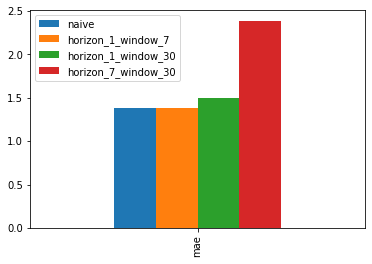

In [216]:
fig, ax = plt.subplots()
pd.DataFrame(
    {
        "naive": naive_results["mae"],
        "horizon_1_window_7": model_1_results["mae"],
        "horizon_1_window_30": model_2_results["mae"],
        "horizon_7_window_30": model_3_results["mae"]
    },
    index=["mae"]).plot(ax=ax, kind="bar")

fig.savefig('./graphs/performance_benchmark_1.png', facecolor='white')

The dense model with a horizon of 1 and a window size of 7 looks to be performing the best.

Because of this, let's use HORIZON=1 and WINDOW_SIZE=7 for our next series of modelling experiments (in other words, we'll use the previous week of temperature to try and predict the next day).

## Model 4: Conv1D

In [217]:
HORIZON = 1
WINDOW_SIZE = 7

In [218]:
train_windows, train_labels = make_windows(y_train.to_numpy(),
                                           window_size=WINDOW_SIZE,
                                           horizon=HORIZON)
val_windows, val_labels = make_windows(y_val.to_numpy(),
                                       window_size=WINDOW_SIZE,
                                       horizon=HORIZON)
test_windows, test_labels = make_windows(y_test.to_numpy(),
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

In [219]:
print(f"train_windows shape: {train_windows.shape}")
print(f"val_windows shape: {val_windows.shape}")
print(f"test_windows shape: {test_windows.shape}")
print("-" * 30)
print(f"train_labels shape: {train_labels.shape}")
print(f"val_labels shape: {val_labels.shape}")
print(f"test_labels shape: {test_labels.shape}")

train_windows shape: (1253, 7)
val_windows shape: (150, 7)
test_windows shape: (152, 7)
------------------------------
train_labels shape: (1253, 1)
val_labels shape: (150, 1)
test_labels shape: (152, 1)


In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential(
    [
        # Create Lambda layer to reshape inputs, without this layer, the model will error
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        layers.Conv1D(
            filters=128, kernel_size=5, padding="causal", activation="relu"),
        layers.Dense(HORIZON)
    ],
    name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            validation_data=(val_windows, val_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [221]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_20 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [222]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

5/5 [==============================] - 0s 6ms/step - loss: 1.4089


1.4089043140411377

In [223]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

5/5 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([21.697233, 22.981934, 23.921427, 23.554056, 22.751118, 21.942375,
       20.596457, 20.217098, 19.783775, 20.903252], dtype=float32)>

In [224]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
pd.Series(model_4_results)

mae     1.408904
mse     3.041346
rmse    1.743945
mape    7.421221
mase    1.016652
dtype: float32

## Model 5: RNN (LSTM)

In [225]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
# expand input dimension to be compatible with LSTM
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            validation_data=(val_windows, val_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


In [226]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

5/5 [==============================] - 0s 4ms/step - loss: 1.4207


1.4207009077072144

In [227]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

5/5 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([21.361956, 23.209719, 24.030602, 23.245556, 22.71002 , 21.843452,
       20.55467 , 20.28591 , 19.860716, 20.882315], dtype=float32)>

In [228]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
pd.Series(model_5_results)

mae     1.420701
mse     3.133509
rmse    1.770172
mape    7.493802
mase    1.025164
dtype: float32

## Optimizing attempts
### One LSTM cell (activation="relu")
- mae     1.334015
- mse     2.797141
- rmse    1.672465
- mape    6.538081
- mase    1.035925
### One LSTM cell (activation="tanh")
- mae     1.412117
- mse     3.029590
- rmse    1.740572
- mape    6.995653
- mase    1.096574
### One LSTM cell (activation="relu") + One Dense(32) layer
- mae     1.326095
- mse     2.832967
- rmse    1.683142
- mape    6.507239
- mase    1.029775
### TWO LSTM cell (activation="relu") + One Dense(32) layer
- mae     1.318385
- mse     2.832050
- rmse    1.682870
- mape    6.468732
- mase    1.023787

# Multivariate predictions

Let's still try to predict `meantemp`, but this time adding other air variables to the equation.

<AxesSubplot:xlabel='date'>

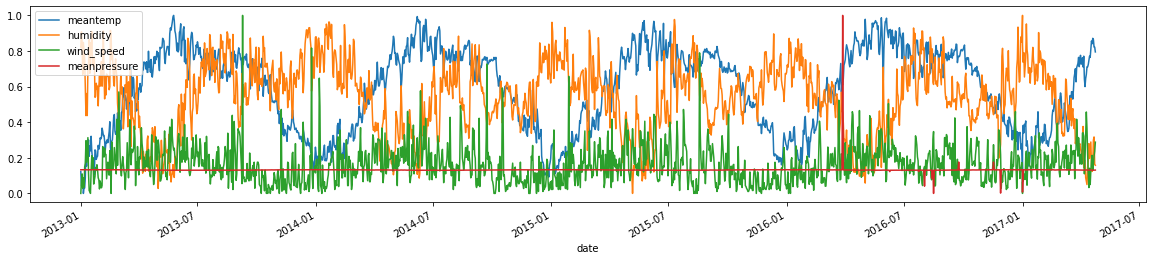

In [16]:
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
scaled_df = pd.DataFrame(minmax_scale(df), columns=df.columns, index=df.index)
fig, ax = plt.subplots(figsize=(20, 4))
scaled_df.plot(ax=ax, style="-")

# fig.savefig('./graphs/data_scaled.png', facecolor='white')

As we can see meanpressure is pretty much constant throughout the dataset and does not seem exploitable

In [17]:
df.drop("meanpressure", axis=1, inplace=True)

In [18]:
df.head()

,meantemp,humidity,wind_speed
date,,,
2013-01-01,10.000000,84.500000,0.000000
2013-01-02,7.400000,92.000000,2.980000
2013-01-03,7.166667,87.000000,4.633333
2013-01-04,8.666667,71.333333,1.233333
2013-01-05,6.000000,86.833333,3.700000


## Making a windowed dataset with pandas

In [19]:
WINDOW_SIZE = 7
HORIZON = 1

In [20]:
df_windowed = df.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):  # Shift values for each step in WINDOW_SIZE
    df_windowed[f"meantemp{-(i+1)}"] = df_windowed["meantemp"].shift(
        periods=i + 1)
df_windowed.head(10)

,meantemp,humidity,wind_speed,meantemp-1,meantemp-2,meantemp-3,meantemp-4,meantemp-5,meantemp-6,meantemp-7
date,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,7.400000,92.000000,2.980000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,7.166667,87.000000,4.633333,7.400000,10.000000,NaN,NaN,NaN,NaN,NaN
2013-01-04,8.666667,71.333333,1.233333,7.166667,7.400000,10.000000,NaN,NaN,NaN,NaN
2013-01-05,6.000000,86.833333,3.700000,8.666667,7.166667,7.400000,10.000000,NaN,NaN,NaN
2013-01-06,7.000000,82.800000,1.480000,6.000000,8.666667,7.166667,7.400000,10.000000,NaN,NaN
2013-01-07,7.000000,78.600000,6.300000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,NaN
2013-01-08,8.857143,63.714286,7.142857,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000
2013-01-09,14.000000,51.250000,12.500000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000


In [21]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = df_windowed.dropna().drop("meantemp", axis=1).astype(np.float32)
y = df_windowed.dropna()["meantemp"].astype(np.float32)
X.head()

,humidity,wind_speed,meantemp-1,meantemp-2,meantemp-3,meantemp-4,meantemp-5,meantemp-6,meantemp-7
date,,,,,,,,,
2013-01-08,63.714287,7.142857,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000
2013-01-09,51.250000,12.500000,8.857142,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000
2013-01-10,62.000000,7.400000,14.000000,8.857142,7.000000,7.000000,6.000000,8.666667,7.166667
2013-01-11,51.285713,10.571428,11.000000,14.000000,8.857142,7.000000,7.000000,6.000000,8.666667
2013-01-12,74.000000,13.228572,15.714286,11.000000,14.000000,8.857142,7.000000,7.000000,6.000000


In [22]:
# View labels
y.head()

date
2013-01-08     8.857142
2013-01-09    14.000000
2013-01-10    11.000000
2013-01-11    15.714286
2013-01-12    14.000000
Name: meantemp, dtype: float32

In [23]:
# Make train, val and test sets
train_size = int(len(X) * TRAIN_SIZE)
val_size = int(len(X) * VAL_SIZE)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size +
                                                      val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [24]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print("-" * 30)
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1255, 9)
X_val shape: (156, 9)
X_test shape: (158, 9)
------------------------------
y_train shape: (1255,)
y_val shape: (156,)
y_test shape: (158,)


## Model 6: Dense (multivariate time series)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential(
    [layers.Dense(128, activation="relu"),
     layers.Dense(HORIZON)],
    name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train,
            y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            validation_data=(X_val, y_val),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [239]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model(
    "model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 1.3595


1.3595328330993652

In [240]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

5/5 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([21.896267, 21.13077 , 21.9334  , 21.71846 , 22.372747, 22.601746,
       22.060179, 23.211174, 24.041447, 23.72908 ], dtype=float32)>

In [241]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test, y_pred=model_6_preds)
pd.Series(model_6_results)

mae     1.359533
mse     2.919399
rmse    1.708625
mape    7.153857
mase    0.986232
dtype: float32

In [242]:
pd.Series(model_1_results)

mae     1.375500
mse     3.004024
rmse    1.733212
mape    7.297487
mase    0.992547
dtype: float32

## Model 7: Multivariate LSTM

In [215]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(X_train.shape[1]))
# expand input dimension to be compatible with LSTM
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.Bidirectional(layers.LSTM(128))(x)
x = layers.Dense(32)(x)
output = layers.Dense(HORIZON)(x)
model_7 = tf.keras.Model(inputs=inputs,
                         outputs=output,
                         name="model_7_lstm_multivariate")

# Compile model
model_7.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))

history = model_7.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    validation_data=(X_val, y_val))


5/5 [==============================] - 0s 4ms/step


mae     1.341849
mse     2.949398
rmse    1.717381
mape    6.941949
mase    0.973403
dtype: float32

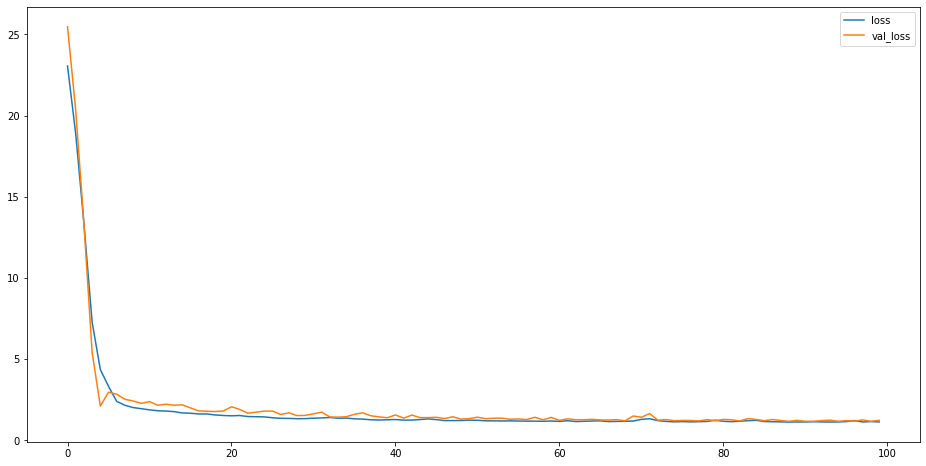

In [216]:
pd.DataFrame(history.history).plot(figsize=(16,8))
model_7_preds = tf.squeeze(model_7.predict(X_test))
model_7_results = evaluate_preds(y_true=y_test, y_pred=model_7_preds)
pd.Series(model_7_results)

## Model 8: Multivariate Conv1D

In [207]:
tf.random.set_seed(42)

model_8 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, padding="causal", activation="gelu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(HORIZON)
],
                              name="model_8_conv1D")

model_8.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(8e-4))

model_8.fit(X_train,
            y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            validation_data=(X_val, y_val))

5/5 [==============================] - 0s 4ms/step


mae     1.289598
mse     2.643011
rmse    1.625734
mape    6.787092
mase    0.935500
dtype: float32

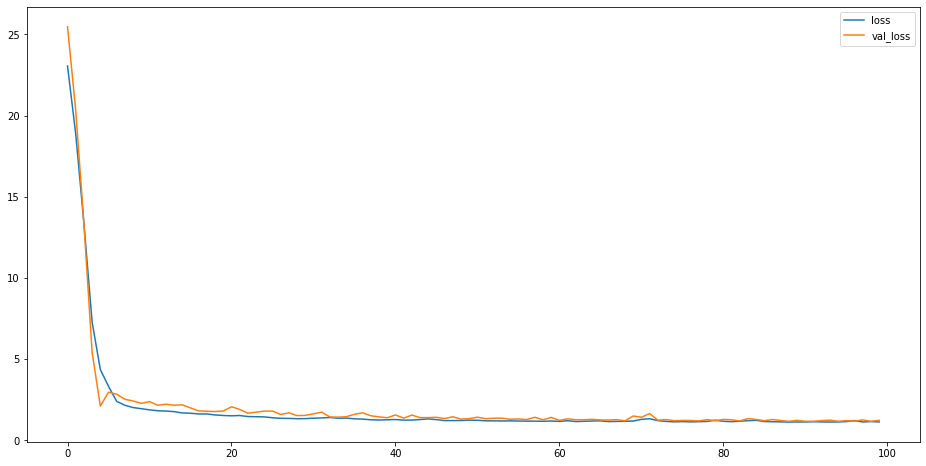

In [208]:
pd.DataFrame(history.history).plot(figsize=(16,8))
model_8_preds = tf.squeeze(model_8.predict(X_test))
model_8_results = evaluate_preds(y_true=y_test, y_pred=model_8_preds)
pd.Series(model_8_results)

## Model 9: N-BEATS algorithm

[N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) paper](https://arxiv.org/pdf/1905.10437.pdf)

In [25]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):

    def __init__(self, input_size: int, theta_size: int, horizon: int,
                 n_neurons: int, n_layers: int, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [
            tf.keras.layers.Dense(n_neurons, activation="relu")
            for _ in range(n_layers)
        ]
        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size,
                                                 activation="linear",
                                                 name="theta")

    # the call method is what runs when the layer is called
    def call(self, inputs):
        x = inputs
        for layer in self.hidden:  # pass inputs through each hidden layer
            x = layer(x)
        theta = self.theta_layer(x)
        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:,
                                                               -self.horizon:]
        return backcast, forecast


In [26]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(
    input_size=WINDOW_SIZE,
    theta_size=WINDOW_SIZE + HORIZON,  # backcast + forecast 
    horizon=HORIZON,
    n_neurons=128,
    n_layers=4)


In [28]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(
    tf.range(WINDOW_SIZE) + 1, axis=0
)  # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [29]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.41964003  0.07209616 -0.47363216  0.8934144  -0.6582925   0.10430966
  0.9448269 ]
Forecast: -0.9532116651535034
